In [1]:
import os
import sys
import scipy.io
import scipy.misc
import matplotlib.pyplot as plt
from matplotlib.pyplot import imshow
from PIL import Image
from nst_utils import *
import numpy as np
import tensorflow as tf
from model_utility import *
import skimage
%matplotlib inline

In [2]:
model = load_vgg_model("imagenet-vgg-verydeep-19.mat")
print(model)

{'conv2_2': <tf.Tensor 'Relu_3:0' shape=(1, 150, 200, 128) dtype=float32>, 'conv3_1': <tf.Tensor 'Relu_4:0' shape=(1, 75, 100, 256) dtype=float32>, 'conv1_1': <tf.Tensor 'Relu:0' shape=(1, 300, 400, 64) dtype=float32>, 'avgpool3': <tf.Tensor 'AvgPool_2:0' shape=(1, 38, 50, 256) dtype=float32>, 'conv5_3': <tf.Tensor 'Relu_14:0' shape=(1, 19, 25, 512) dtype=float32>, 'conv5_4': <tf.Tensor 'Relu_15:0' shape=(1, 19, 25, 512) dtype=float32>, 'avgpool1': <tf.Tensor 'AvgPool:0' shape=(1, 150, 200, 64) dtype=float32>, 'input': <tf.Variable 'Variable:0' shape=(1, 300, 400, 3) dtype=float32_ref>, 'conv3_2': <tf.Tensor 'Relu_5:0' shape=(1, 75, 100, 256) dtype=float32>, 'conv4_3': <tf.Tensor 'Relu_10:0' shape=(1, 38, 50, 512) dtype=float32>, 'conv4_1': <tf.Tensor 'Relu_8:0' shape=(1, 38, 50, 512) dtype=float32>, 'conv4_4': <tf.Tensor 'Relu_11:0' shape=(1, 38, 50, 512) dtype=float32>, 'avgpool4': <tf.Tensor 'AvgPool_3:0' shape=(1, 19, 25, 512) dtype=float32>, 'conv4_2': <tf.Tensor 'Relu_9:0' shape=

C:\Users\Ashutosh\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.
  """Entry point for launching an IPython kernel.
C:\Users\Ashutosh\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.
  


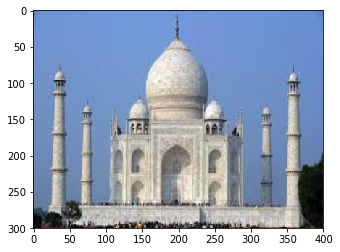

In [3]:
content_image = scipy.misc.imread("content.png")
content_image = scipy.misc.imresize(content_image, (300, 400))
imshow(content_image)

C:\Users\Ashutosh\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.
  """Entry point for launching an IPython kernel.
C:\Users\Ashutosh\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.
  


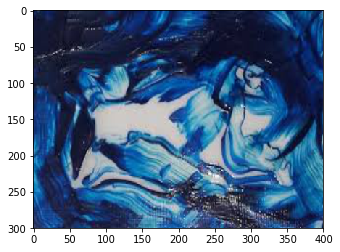

In [4]:
style_image = scipy.misc.imread("style_image.png")
style_image = scipy.misc.imresize(style_image, (300, 400))
imshow(style_image)

In [5]:
STYLE_LAYERS = [
    ('conv1_1', 0.2),
    ('conv2_1', 0.2),
    ('conv3_1', 0.2),
    ('conv4_1', 0.2),
    ('conv5_1', 0.2)]

In [6]:
# Reset the graph
tf.reset_default_graph()

# Start interactive session
sess = tf.InteractiveSession()

In [7]:
content_image = reshape_and_normalize_image(content_image)
style_image = reshape_and_normalize_image(style_image)

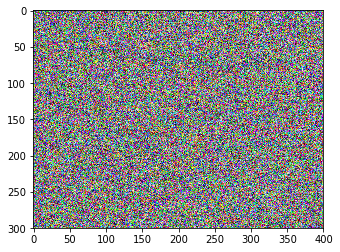

In [8]:
generated_image = generate_noise_image(content_image)
imshow(generated_image[0])

In [9]:
model = load_vgg_model("imagenet-vgg-verydeep-19.mat")

In [10]:
sess.run(model['input'].assign(content_image))
out = model['conv4_2']
a_C = sess.run(out)
a_G = out
J_content = compute_content_cost(a_C, a_G)

In [11]:
def compute_style_cost(model, STYLE_LAYERS):
    J_style = 0
    for layer_name, coeff in STYLE_LAYERS:
        out = model[layer_name]
        a_S = sess.run(out)
        a_G = out
        J_style_layer = compute_layer_style_cost(a_S, a_G)
        J_style += coeff * J_style_layer
    return J_style

In [12]:
sess.run(model['input'].assign(style_image))
J_style = compute_style_cost(model, STYLE_LAYERS)

In [13]:
J = total_cost(J_content,J_style,10,40)

In [14]:
optimizer = tf.train.AdamOptimizer(2.0)
train_step = optimizer.minimize(J)

In [15]:
def model_nn(sess, input_image, num_iterations = 200):
    sess.run(tf.global_variables_initializer())
    sess.run(model['input'].assign(input_image))
    for i in range(num_iterations):
        sess.run(train_step)
        generated_image = sess.run(model['input'])
        if i%20 == 0:
            Jt, Jc, Js = sess.run([J, J_content, J_style])
            print("Iteration " + str(i) + " :")
            print("total cost = " + str(Jt))
            print("content cost = " + str(Jc))
            print("style cost = " + str(Js))
            save_image("output/" + str(i) + ".png", generated_image)
    save_image('output/generated_image.jpg', generated_image)
    return generated_image

In [16]:
model_nn(sess, generated_image)

Iteration 0 :
total cost = 1.91583e+10
content cost = 9296.26
style cost = 4.78955e+08
Iteration 20 :
total cost = 4.21377e+09
content cost = 22645.1
style cost = 1.05339e+08
Iteration 40 :
total cost = 1.5678e+09
content cost = 25198.2
style cost = 3.91886e+07
Iteration 60 :
total cost = 8.35556e+08
content cost = 25873.9
style cost = 2.08824e+07
Iteration 80 :
total cost = 5.59296e+08
content cost = 26219.0
style cost = 1.39758e+07
Iteration 100 :
total cost = 4.17465e+08
content cost = 26544.7
style cost = 1.043e+07
Iteration 120 :
total cost = 3.31234e+08
content cost = 26847.6
style cost = 8.27413e+06
Iteration 140 :
total cost = 2.73177e+08
content cost = 27096.8
style cost = 6.82266e+06
Iteration 160 :
total cost = 2.31019e+08
content cost = 27325.1
style cost = 5.76865e+06
Iteration 180 :
total cost = 1.98905e+08
content cost = 27543.0
style cost = 4.96573e+06


array([[[[  77.24384308,   68.74508667,  135.55754089],
         [  56.84522247,   42.62360764,   93.77294922],
         [  56.0488205 ,   43.04532242,  111.9214325 ],
         ..., 
         [  12.35025024,   57.84295273,   87.23332214],
         [ -99.63226318,  -70.44114685,  -31.3747654 ],
         [ -75.98088837,  -56.69458389,   -1.18565786]],

        [[ 104.44085693,   89.47651672,  139.99935913],
         [  50.56320953,   48.44918442,   90.02479553],
         [ -54.99772644,  -24.23976707,   52.12852859],
         ..., 
         [  16.00470161,   51.45555496,   58.85055542],
         [-106.97748566,  -56.95084   ,  -10.6476841 ],
         [ -68.8549118 ,  -56.26728439,  -14.79808712]],

        [[  96.99835968,   76.21844482,  117.31021881],
         [  14.9914484 ,   33.31604767,   86.18359375],
         [ -44.50078964,  -13.51682949,   70.86993408],
         ..., 
         [  -8.64055443,   27.76566315,   65.26155853],
         [  19.64069557,   39.28493118,   80.29594421],